In [ ]:
!pip install torchaudio librosa speechbrain

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def extract_mel_spectrogram(audio_path):
    """Loads audio and converts it to a Mel spectrogram"""
    waveform, sample_rate = torchaudio.load(audio_path)
    mel_transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=128)
    mel_spectrogram = mel_transform(waveform).squeeze(0)
    return mel_spectrogram

def preprocess_mel_spectrogram(mel_spectrogram, target_shape=(128, 200)):
    """Pads or truncates Mel spectrograms to a fixed shape"""
    num_freq_bins, num_time_frames = mel_spectrogram.shape

    if num_time_frames < target_shape[1]:
        pad_amount = target_shape[1] - num_time_frames
        mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, pad_amount))
    else:
        mel_spectrogram = mel_spectrogram[:, :target_shape[1]]

    return mel_spectrogram


In [ ]:
def process_audio_files(audio_dir):
    """Extracts Mel spectrograms from dataset"""
    data = []
    for accent in ['american', 'indian']:
        accent_dir = os.path.join(audio_dir, accent)
        for speaker_folder in os.listdir(accent_dir):
            speaker_dir = os.path.join(accent_dir, speaker_folder)
            if os.path.isdir(speaker_dir):
                for audio_file in os.listdir(speaker_dir):
                    if audio_file.endswith('.wav'):
                        audio_path = os.path.join(speaker_dir, audio_file)
                        mel_spec = extract_mel_spectrogram(audio_path)
                        mel_spec = preprocess_mel_spectrogram(mel_spec)

                        data.append({
                            'features': mel_spec,
                            'accent': 0 if accent == 'american' else 1
                        })
    return data

dataset_features = process_audio_files(dataset_path)


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 🛠 Step 1: Dataset & Dataloader Functions
def create_dataset(data):
    return [(item["features"], item["accent"]) for item in data]

def collate_fn(batch):
    features = [item[0] for item in batch]
    accents = [item[1] for item in batch]

    padded_features = pad_sequence(features, batch_first=True, padding_value=0.0)
    padded_features = padded_features.unsqueeze(1)

    accents = torch.tensor(accents, dtype=torch.long)
    return padded_features, accents


def get_dataloader(dataset, batch_size=16):
    return DataLoader(create_dataset(dataset), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# 🛠 Step 2: Model Functions
def get_fc1_input_size():
    with torch.no_grad():
        sample_input = torch.zeros(1, 1, 128, 200)  # (Batch, Channels, Height, Width)
        sample_output = nn.MaxPool2d(2, 2)(torch.relu(nn.Conv2d(1, 64, kernel_size=3, padding=1)(sample_input)))
        sample_output = nn.MaxPool2d(2, 2)(torch.relu(nn.Conv2d(64, 128, kernel_size=3, padding=1)(sample_output)))
        return sample_output.numel()

def build_model():
    fc1_input_size = get_fc1_input_size()

    return nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(fc1_input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )

# 🛠 Step 3: Training Function
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for real_features, accent in train_loader:
            real_features, accent = real_features.to(device), accent.to(device)

            optimizer.zero_grad()
            outputs = model(real_features)
            loss = criterion(outputs, accent)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# 🛠 Step 4: Run the Training Pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = get_dataloader(dataset_features)
model = build_model().to(device)

train_model(model, train_loader)


Epoch 1/10, Loss: 244.7851
Epoch 2/10, Loss: 16.3972
Epoch 3/10, Loss: 5.5214
Epoch 4/10, Loss: 4.0789
Epoch 5/10, Loss: 10.3893
Epoch 6/10, Loss: 1.9831
Epoch 7/10, Loss: 0.8052
Epoch 8/10, Loss: 0.2451
Epoch 9/10, Loss: 0.0257
Epoch 10/10, Loss: 0.0099


In [ ]:
# 🛠 Function to Test Model Accuracy
def test_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for real_features, accent in test_loader:
            real_features, accent = real_features.to(device), accent.to(device)
            outputs = model(real_features)
            _, predicted = torch.max(outputs, 1)  # Get predicted class

            correct += (predicted == accent).sum().item()
            total += accent.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `dataset_features` is your full dataset
train_data, test_data = train_test_split(dataset_features, test_size=0.2, random_state=42)


In [ ]:
# Get DataLoader for the test dataset
test_loader = get_dataloader(test_data, batch_size=16)


In [ ]:
test_model(model, test_loader)

Test Accuracy: 100.00%


In [ ]:
# Get a sample from the test set
sample_features, sample_accent = next(iter(test_loader))

# Move sample to device
sample_features = sample_features.to(device)

# Get prediction
with torch.no_grad():
    predicted_accent = model(sample_features)
    _, predicted_label = torch.max(predicted_accent, 1)

print(f"Original Accent: {sample_accent[0].item()}, Predicted Accent: {predicted_label[0].item()}")


Original Accent: 1, Predicted Accent: 1


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store stats for graph plotting
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for real_features, accent in train_loader:
            real_features, accent = real_features.to(device), accent.to(device)

            optimizer.zero_grad()
            outputs = model(real_features)
            loss = criterion(outputs, accent)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == accent).sum().item()
            total += accent.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = (correct / total) * 100

        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Plot Loss & Accuracy Graphs
    plot_training_stats(epoch_losses, epoch_accuracies)


In [ ]:
def plot_training_stats(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', linestyle='-', color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)

    # Accuracy Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')
    plt.grid(True)

    plt.show()


Epoch 1/10, Loss: 0.0666, Accuracy: 98.62%
Epoch 2/10, Loss: 0.0505, Accuracy: 99.36%
Epoch 3/10, Loss: 0.0277, Accuracy: 99.16%
Epoch 4/10, Loss: 0.0222, Accuracy: 99.49%
Epoch 5/10, Loss: 0.0003, Accuracy: 100.00%
Epoch 6/10, Loss: 0.0001, Accuracy: 100.00%
Epoch 7/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0000, Accuracy: 100.00%


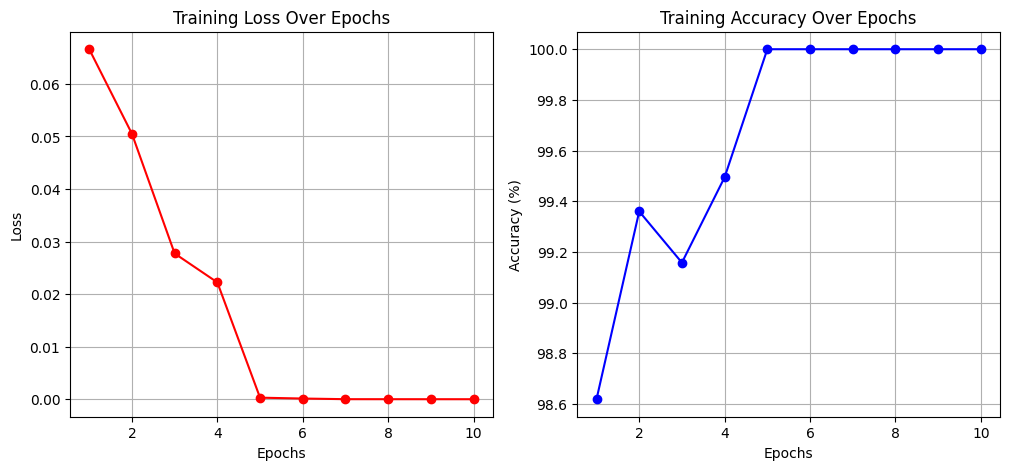

In [ ]:
train_model(model, train_loader)


In [ ]:
import numpy as np
import seaborn as sns

def plot_feature_distribution(dataset):
    feature_lengths = [item["features"].shape[0] for item in dataset]  # Length of each feature vector
    plt.figure(figsize=(8, 5))
    sns.histplot(feature_lengths, bins=20, kde=True, color="green")
    plt.xlabel("Feature Length")
    plt.ylabel("Count")
    plt.title("Distribution of Feature Lengths in Dataset")
    plt.show()


In [ ]:
from collections import Counter

def plot_accent_distribution(dataset):
    accents = [item["accent"] for item in dataset]
    class_counts = Counter(accents)

    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color="blue")
    plt.xlabel("Accent Class")
    plt.ylabel("Number of Samples")
    plt.title("Accent Class Distribution")
    plt.xticks(list(class_counts.keys()))  # Ensure all classes are labeled
    plt.show()


In [ ]:
import torchaudio

def plot_spectrogram(example_audio, sample_rate=16000):
    plt.figure(figsize=(10, 4))
    plt.specgram(example_audio.numpy(), NFFT=1024, Fs=sample_rate, cmap="inferno")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Spectrogram of a Sample Audio")
    plt.colorbar(label="Intensity (dB)")
    plt.show()


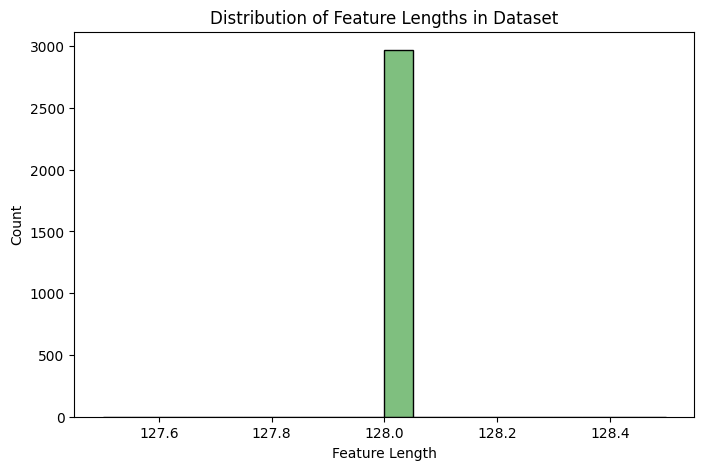

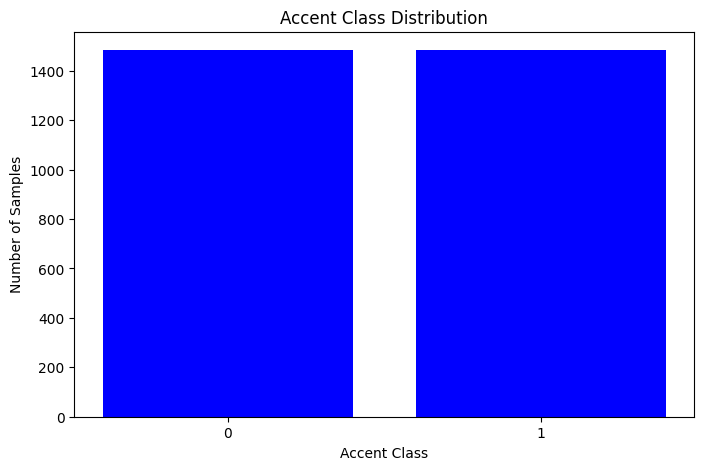

<ipython-input-59-1b9e414f657d>:5: UserWarning: Only one segment is calculated since parameter NFFT (=1024) >= signal length (=128).
  plt.specgram(example_audio.numpy(), NFFT=1024, Fs=sample_rate, cmap="inferno")
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


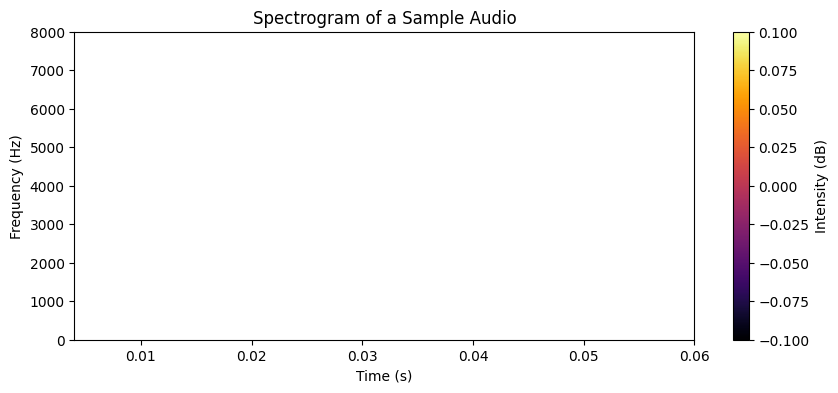

In [ ]:
plot_feature_distribution(dataset_features)
plot_accent_distribution(dataset_features)

# Get a random sample and visualize spectrogram
sample_audio, _ = dataset_features[0]["features"], dataset_features[0]["accent"]
plot_spectrogram(sample_audio)


In [ ]:
import torch

# Save the model
model_path = "accent_conversion_model.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved as {model_path}")


Model saved as accent_conversion_model.pth


In [ ]:
from google.colab import files
files.download("accent_conversion_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>